# Neural Scaling Laws Analysis

This notebook analyzes training runs to visualize neural scaling laws as described in the OpenAI paper "Scaling Laws for Neural Language Models" (Kaplan et al., 2020).

## Understanding the Scaling Law

The OpenAI scaling law paper establishes that the test loss of a Transformer trained autoregressively on language modeling follows predictable power-law relationships with three key factors:

### 1. Scaling with Compute ($C_{\text{min}}$)

When training is compute-optimal (neither undertrained nor overtrained), the loss scales as:

$$L(C) = \left(\frac{C_{\text{min}}}{C_0}\right)^{-\alpha_C}$$

Where:
- $C_{\text{min}}$ is the compute budget in PetaFLOP-days
- $C_0 \approx 2.3 \times 10^8$ PF-days (a constant)
- $\alpha_C \approx 0.050$ (the compute scaling exponent)

This means **loss decreases as a power law with compute** - each 10x increase in compute reduces loss by a predictable amount.

### 2. Scaling with Model Size ($N$)

For models trained to convergence on sufficient data:

$$L(N) = \left(\frac{N_c}{N}\right)^{\alpha_N}$$

Where:
- $N$ is the number of non-embedding parameters
- $N_c \approx 8.8 \times 10^{13}$ parameters
- $\alpha_N \approx 0.076$

### 3. Key Insights

1. **Power laws are universal**: The same exponents apply across different model sizes
2. **Compute efficiency frontier**: There's an optimal model size for each compute budget
3. **Predictability**: We can extrapolate performance of larger models from smaller ones
4. **Diminishing returns**: Due to the small exponent (~0.05), you need ~10x more compute to reduce loss by ~12%

### The Formula We'll Plot

From the paper's Figure 1, the compute-optimal frontier follows:

$$L = \left(\frac{C_{\text{min}}}{2.3 \times 10^8}\right)^{-0.050}$$

where $C_{\text{min}}$ is in PetaFLOP-days.

**Note on units**: Our data uses cumulative PetaFLOPs (10^15 FLOPs). The OpenAI paper uses PF-days. For comparison purposes, we plot the scaling law line using the same units as our data.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterMathtext
import warnings
warnings.filterwarnings('ignore')

# Set style for clean plots
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.facecolor'] = 'white'

In [26]:
# Load the data
df = pd.read_csv('/Users/timur/Desktop/Relace/wandb_friday/dense_analysis/wandb_export_2026-01-16T15_40_29.001-08_00.csv')

print(f"Data shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Data shape: (37282, 61)

Columns: ['throughput/total petaflops', 'saturate_30M_15B - train/CE loss', 'saturate_30M_15B - train/CE loss__MIN', 'saturate_30M_15B - train/CE loss__MAX', 'saturate_30M_15B - _step', 'saturate_30M_15B - _step__MIN', 'saturate_30M_15B - _step__MAX', 'saturate_500K_15B - train/CE loss', 'saturate_500K_15B - train/CE loss__MIN', 'saturate_500K_15B - train/CE loss__MAX', 'saturate_500K_15B - _step', 'saturate_500K_15B - _step__MIN', 'saturate_500K_15B - _step__MAX', 'saturate_1B_15B.py - train/CE loss', 'saturate_1B_15B.py - train/CE loss__MIN', 'saturate_1B_15B.py - train/CE loss__MAX', 'saturate_1B_15B.py - _step', 'saturate_1B_15B.py - _step__MIN', 'saturate_1B_15B.py - _step__MAX', 'saturate_3B_15B - train/CE loss', 'saturate_3B_15B - train/CE loss__MIN', 'saturate_3B_15B - train/CE loss__MAX', 'saturate_3B_15B - _step', 'saturate_3B_15B - _step__MIN', 'saturate_3B_15B - _step__MAX', 'saturate_1M_15B_2 - train/CE loss', 'saturate_1M_15B_2 - train/CE loss__MI

In [27]:
# Extract model runs from columns
# The format is: "model_name - metric"

# Get unique model names
model_names = set()
for col in df.columns:
    if ' - ' in col:
        model_name = col.split(' - ')[0]
        model_names.add(model_name)

print("Found models:")
for name in sorted(model_names):
    print(f"  - {name}")

Found models:
  - saturate_135M_15B_03
  - saturate_1B_15B.py
  - saturate_1M_15B_2
  - saturate_2.5M_15B
  - saturate_271M_15B_2
  - saturate_271M_15_2_cont
  - saturate_30M_15B
  - saturate_3B_15B
  - saturate_500K_15B
  - saturate_60M_15B


In [28]:
# Extract data for each model
# We need: petaflops (x-axis), loss, and step

def extract_model_data(df, model_name):
    """Extract petaflops, loss, and step data for a model."""
    loss_col = f"{model_name} - train/CE loss"
    step_col = f"{model_name} - _step"
    pf_col = "throughput/total petaflops"
    
    if loss_col not in df.columns:
        return None
    
    # Get rows where this model has data
    mask = df[loss_col].notna() & (df[loss_col] != '')
    
    if mask.sum() == 0:
        return None
    
    data = pd.DataFrame({
        'petaflops': pd.to_numeric(df.loc[mask, pf_col], errors='coerce'),
        'loss': pd.to_numeric(df.loc[mask, loss_col], errors='coerce'),
        'step': pd.to_numeric(df.loc[mask, step_col], errors='coerce')
    }).dropna()
    
    return data.sort_values('step').reset_index(drop=True)

# Extract data for all models
model_data = {}
for name in sorted(model_names):
    data = extract_model_data(df, name)
    if data is not None and len(data) > 0:
        model_data[name] = data
        print(f"{name}: {len(data)} data points, steps {int(data['step'].min())}-{int(data['step'].max())}")

saturate_135M_15B_03: 2998 data points, steps 2-3000
saturate_1B_15B.py: 2157 data points, steps 2-2159
saturate_1M_15B_2: 11997 data points, steps 2-12000
saturate_2.5M_15B: 5999 data points, steps 2-6000
saturate_271M_15B_2: 510 data points, steps 2-511
saturate_271M_15_2_cont: 3182 data points, steps 513-3694
saturate_30M_15B: 1133 data points, steps 2-1134
saturate_3B_15B: 1318 data points, steps 2-1319
saturate_500K_15B: 4993 data points, steps 2-4994
saturate_60M_15B: 2997 data points, steps 2-3000


In [29]:
# Merge continuation runs (e.g., 271M_15B_2 and 271M_15_2_cont)
# These should be concatenated based on step number

def merge_runs(model_data, base_name, cont_name, merged_name):
    """Merge a base run with its continuation."""
    if base_name not in model_data or cont_name not in model_data:
        return
    
    base = model_data[base_name]
    cont = model_data[cont_name]
    
    # Concatenate - continuation has higher steps
    merged = pd.concat([base, cont], ignore_index=True).sort_values('step').reset_index(drop=True)
    model_data[merged_name] = merged
    print(f"Merged {base_name} + {cont_name} -> {merged_name}: {len(merged)} points")
    
    # Remove the individual runs
    del model_data[base_name]
    del model_data[cont_name]

# Merge 271M runs
merge_runs(model_data, 'saturate_271M_15B_2', 'saturate_271M_15_2_cont', '271M')

print("\nFinal models:")
for name in sorted(model_data.keys()):
    data = model_data[name]
    print(f"  {name}: {len(data)} points, loss {data['loss'].min():.3f}-{data['loss'].max():.3f}")

Merged saturate_271M_15B_2 + saturate_271M_15_2_cont -> 271M: 3692 points

Final models:
  271M: 3692 points, loss 3.213-10.903
  saturate_135M_15B_03: 2998 points, loss 3.373-10.928
  saturate_1B_15B.py: 2157 points, loss 3.253-10.890
  saturate_1M_15B_2: 11997 points, loss 5.627-10.828
  saturate_2.5M_15B: 5999 points, loss 4.981-10.833
  saturate_30M_15B: 1133 points, loss 4.326-10.877
  saturate_3B_15B: 1318 points, loss 3.285-11.876
  saturate_500K_15B: 4993 points, loss 6.648-10.826
  saturate_60M_15B: 2997 points, loss 3.646-10.881


In [30]:
# Create clean model names and assign colors
# Sort by approximate model size for consistent coloring

def get_model_size_order(name):
    """Extract approximate model size for sorting."""
    import re
    name_lower = name.lower()
    
    # Look for patterns like 500K, 1M, 2.5M, 30M, 60M, 135M, 271M, 1B, 3B
    # Handle billions first
    if '3b' in name_lower:
        return 3e9
    if '1b' in name_lower:
        return 1e9
    
    # Handle millions - be specific to avoid matching substrings
    if '271m' in name_lower:
        return 271e6
    if '135m' in name_lower:
        return 135e6
    if '60m' in name_lower:
        return 60e6
    if '30m' in name_lower:
        return 30e6
    if '2.5m' in name_lower:
        return 2.5e6
    # Match _1M_ or _1m_ specifically (not 135M etc)
    if re.search(r'[_-]1m[_-]|^1m|_1m$', name_lower):
        return 1e6
    # Handle 500K
    if '500k' in name_lower:
        return 500e3
    return 0

def clean_model_name(name):
    """Create a cleaner display name."""
    name = name.replace('saturate_', '').replace('_15B', '').replace('_15B_2', '')
    name = name.replace('_03', '').replace('.py', '').replace('_2', '')
    return name

# Sort models by size
sorted_models = sorted(model_data.keys(), key=get_model_size_order)

# Assign colors using a colormap
cmap = plt.cm.Blues
n_models = len(sorted_models)
colors = {name: cmap(0.3 + 0.6 * i / max(n_models - 1, 1)) for i, name in enumerate(sorted_models)}

print("Model order (by size):")
for name in sorted_models:
    size = get_model_size_order(name)
    print(f"  {clean_model_name(name)} ({size:.0e} params)")

Model order (by size):
  500K (5e+05 params)
  1M (1e+06 params)
  2.5M (2e+06 params)
  30M (3e+07 params)
  60M (6e+07 params)
  135M (1e+08 params)
  271M (3e+08 params)
  1B (1e+09 params)
  3B (3e+09 params)


In [31]:
# Define the OpenAI scaling law function
# L = (C_min / 2.3e8)^(-0.050)

def openai_scaling_law(C_min, C0=2.3e8, alpha=0.050):
    """OpenAI scaling law: L = (C_min / C0)^(-alpha)
    
    Args:
        C_min: Compute in PetaFLOP-days
        C0: Constant from paper (2.3e8 PF-days)
        alpha: Scaling exponent (0.050)
    
    Returns:
        Predicted loss
    """
    return (C_min / C0) ** (-alpha)

# Get the range of petaflops across all models
all_pf = pd.concat([data['petaflops'] for data in model_data.values()])
pf_min = all_pf.min()
pf_max = all_pf.max()

# Extend the range a bit to the right for projection
pf_extended_max = pf_max * 2

print(f"PetaFLOPs range: {pf_min:.2e} to {pf_max:.2e}")
print(f"Extended range for projection: up to {pf_extended_max:.2e}")

# Create PF range for scaling law line
pf_line = np.logspace(np.log10(pf_min * 0.5), np.log10(pf_extended_max), 100)

PetaFLOPs range: 5.05e-03 to 2.67e+04
Extended range for projection: up to 5.35e+04


## Plot 1: Linear Loss vs Steps

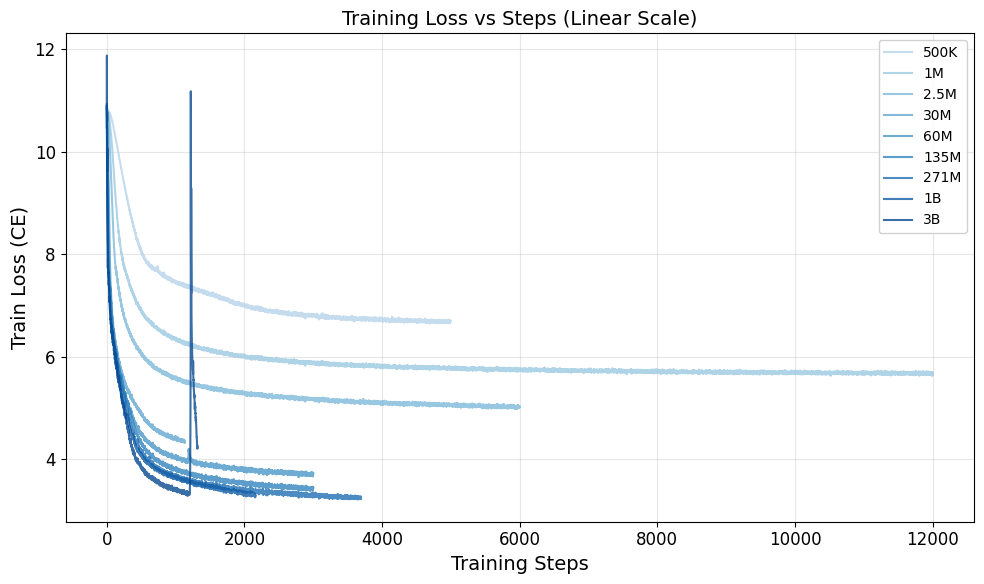

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

for name in sorted_models:
    data = model_data[name]
    ax.plot(data['step'], data['loss'], 
            color=colors[name], alpha=0.8, linewidth=1.5,
            label=clean_model_name(name))

ax.set_xlabel('Training Steps')
ax.set_ylabel('Train Loss (CE)')
ax.set_title('Training Loss vs Steps (Linear Scale)')
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_friday/dense_analysis/plot1_linear_loss_steps.png', dpi=150, bbox_inches='tight')
plt.show()

## Plot 2: Log Loss vs Log Steps

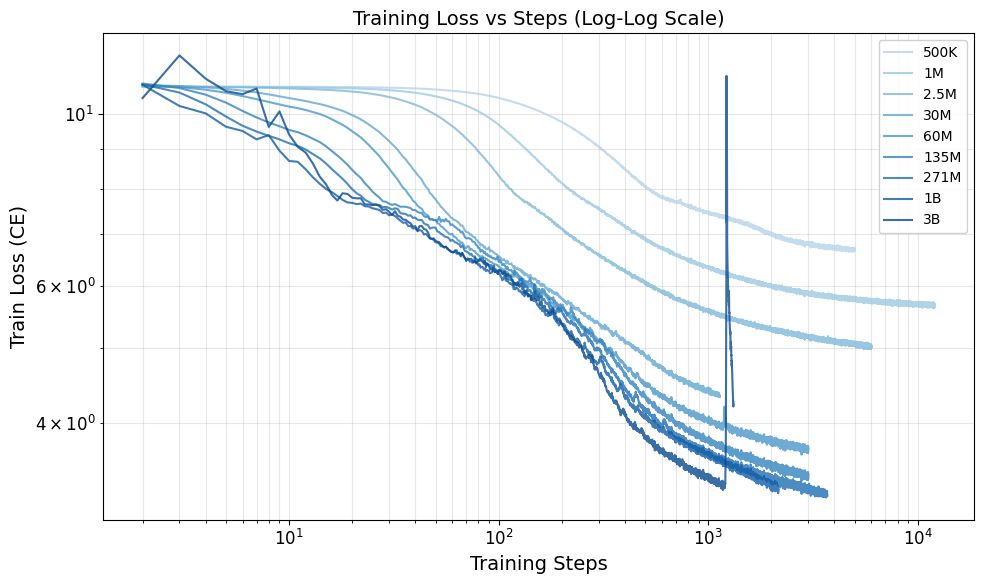

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

for name in sorted_models:
    data = model_data[name]
    ax.plot(data['step'], data['loss'], 
            color=colors[name], alpha=0.8, linewidth=1.5,
            label=clean_model_name(name))

# Plot OpenAI scaling law (we need to map steps to compute for this)
# Since step-to-compute mapping varies by model, we skip the scaling law on this plot

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Training Steps')
ax.set_ylabel('Train Loss (CE)')
ax.set_title('Training Loss vs Steps (Log-Log Scale)')
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_friday/dense_analysis/plot2_log_loss_log_steps.png', dpi=150, bbox_inches='tight')
plt.show()

## Plot 3: Log Loss vs Log PetaFLOPs

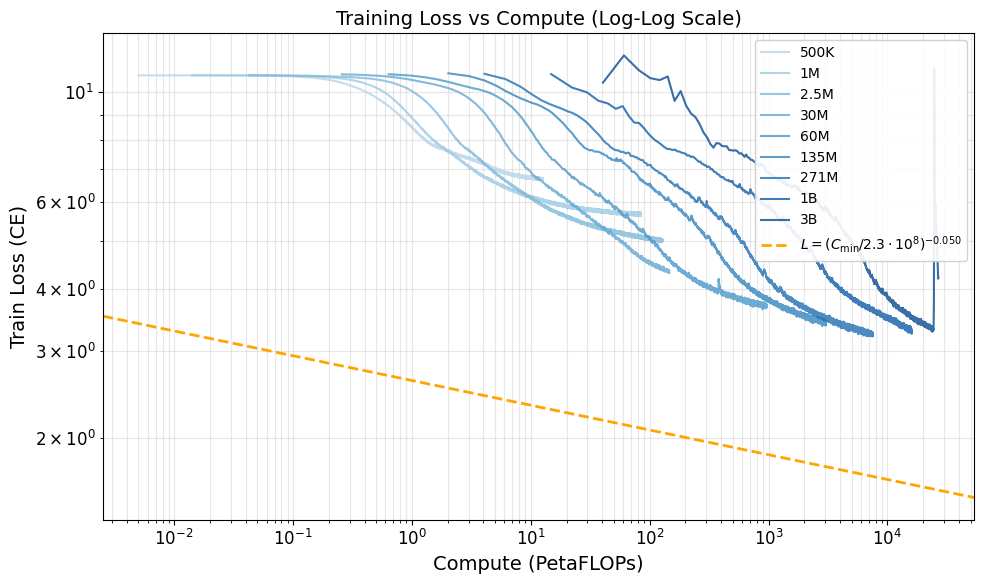

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot model training curves
for name in sorted_models:
    data = model_data[name]
    ax.plot(data['petaflops'], data['loss'], 
            color=colors[name], alpha=0.8, linewidth=1.5,
            label=clean_model_name(name))

# Plot OpenAI scaling law
scaling_loss = openai_scaling_law(pf_line)
ax.plot(pf_line, scaling_loss, '--', color='orange', linewidth=2, 
        label=r'$L = (C_{\min}/2.3 \cdot 10^8)^{-0.050}$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Compute (PetaFLOPs)')
ax.set_ylabel('Train Loss (CE)')
ax.set_title('Training Loss vs Compute (Log-Log Scale)')
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.3, which='both')

# Set x-axis limits with extension
ax.set_xlim(pf_min * 0.5, pf_extended_max)

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_friday/dense_analysis/plot3_log_loss_log_pf.png', dpi=150, bbox_inches='tight')
plt.show()

## Plot 4: OpenAI-Style Scaling Law Plot

Replicating the style from the OpenAI paper Figure 1.

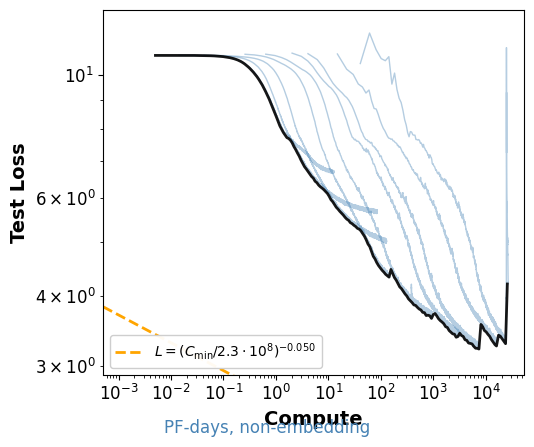

In [35]:
# Create figure matching the OpenAI paper style
# The original appears to be roughly 5.5 x 4.5 inches
fig, ax = plt.subplots(figsize=(5.5, 4.5))

# Plot all training runs in light blue with varying alpha
for i, name in enumerate(sorted_models):
    data = model_data[name]
    # All lines in similar light blue, with slight variation
    ax.plot(data['petaflops'], data['loss'], 
            color='steelblue', alpha=0.4, linewidth=1)

# Find and plot the Pareto frontier (minimum loss at each compute level)
# This represents the compute-optimal training curve
all_data = pd.concat([data.assign(model=name) for name, data in model_data.items()])

# Bin by petaflops and find minimum loss in each bin
all_data['pf_bin'] = pd.cut(np.log10(all_data['petaflops']), bins=200)
frontier = all_data.groupby('pf_bin').agg({
    'petaflops': 'mean',
    'loss': 'min'
}).dropna().sort_values('petaflops')

# Plot the frontier in black
ax.plot(frontier['petaflops'], frontier['loss'], 
        color='black', linewidth=2, alpha=0.9)

# Plot OpenAI scaling law - use the full data range plus extension
pf_line_extended = np.logspace(np.log10(pf_min * 0.1), np.log10(pf_extended_max), 200)
scaling_loss_extended = openai_scaling_law(pf_line_extended)

ax.plot(pf_line_extended, scaling_loss_extended, '--', color='orange', linewidth=2,
        label=r'$L = (C_{\min}/2.3 \cdot 10^8)^{-0.050}$')

# Set scales
ax.set_xscale('log')
ax.set_yscale('log')

# Set axis limits based on actual data with extension to the right
ax.set_xlim(pf_min * 0.1, pf_extended_max)

# Get loss range from data
all_losses = pd.concat([data['loss'] for data in model_data.values()])
loss_min = all_losses.min()
loss_max = all_losses.max()
ax.set_ylim(loss_min * 0.9, loss_max * 1.1)

# Labels matching paper style
ax.set_xlabel('Compute', fontsize=14, fontweight='bold')
ax.set_ylabel('Test Loss', fontsize=14, fontweight='bold')

# Add subtitle
fig.text(0.5, 0.02, 'PF-days, non-embedding', ha='center', fontsize=12, color='steelblue')

# Legend in lower left like the paper
ax.legend(loc='lower left', framealpha=0.95, fontsize=10)

# Clean up spines
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for subtitle

plt.savefig('/Users/timur/Desktop/Relace/wandb_friday/dense_analysis/plot4_openai_style.png', dpi=150, bbox_inches='tight')
plt.show()

In [36]:
# Print summary statistics
print("=" * 60)
print("SUMMARY")
print("=" * 60)

for name in sorted_models:
    data = model_data[name]
    print(f"\n{clean_model_name(name)}:")
    print(f"  Steps: {int(data['step'].min())} to {int(data['step'].max())}")
    print(f"  PetaFLOPs: {data['petaflops'].min():.4f} to {data['petaflops'].max():.4f}")
    print(f"  Loss: {data['loss'].max():.3f} -> {data['loss'].min():.3f}")
    
print("\n" + "=" * 60)
print("OpenAI Scaling Law Predictions")
print("=" * 60)
test_pf = [1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4]
for pf in test_pf:
    loss = openai_scaling_law(pf)
    print(f"  C_min = {pf:.0e} PF -> L = {loss:.3f}")

SUMMARY

500K:
  Steps: 2 to 4994
  PetaFLOPs: 0.0050 to 12.5991
  Loss: 10.826 -> 6.648

1M:
  Steps: 2 to 12000
  PetaFLOPs: 0.0141 to 84.5874
  Loss: 10.828 -> 5.627

2.5M:
  Steps: 2 to 6000
  PetaFLOPs: 0.0426 to 127.8088
  Loss: 10.833 -> 4.981

30M:
  Steps: 2 to 1134
  PetaFLOPs: 0.2577 to 146.1312
  Loss: 10.877 -> 4.326

60M:
  Steps: 2 to 3000
  PetaFLOPs: 0.6390 to 958.4507
  Loss: 10.881 -> 3.646

135M:
  Steps: 2 to 3000
  PetaFLOPs: 2.0298 to 3044.7683
  Loss: 10.928 -> 3.373

271M:
  Steps: 2 to 3694
  PetaFLOPs: 4.0787 to 7533.2690
  Loss: 10.903 -> 3.213

1B:
  Steps: 2 to 2159
  PetaFLOPs: 14.8335 to 16012.8037
  Loss: 10.890 -> 3.253

3B:
  Steps: 2 to 1319
  PetaFLOPs: 40.5292 to 26729.0352
  Loss: 11.876 -> 3.285

OpenAI Scaling Law Predictions
  C_min = 1e-06 PF -> L = 5.225
  C_min = 1e-04 PF -> L = 4.150
  C_min = 1e-02 PF -> L = 3.297
  C_min = 1e+00 PF -> L = 2.619
  C_min = 1e+02 PF -> L = 2.080
  C_min = 1e+04 PF -> L = 1.652
